In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys 
import mdtraj

import torch
from torch.optim import Adam
from torchmd.potentials import ExcludedVolume
from torchmd.sovlers import odeint_adjoint, odeint
from nglview import show_ase, show_file, show_mdtraj
from ase.visualize import view

from nff.nn.layers import GaussianSmearing
from ase import Atoms
from math import sqrt

from torchmd.system import GNNPotentials,PairPotentials,System,Stack
from torchmd.md import Simulations

import ase 
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rc('lines', linewidth=3, color='g')
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams["xtick.major.size"] = 6
matplotlib.rcParams["ytick.major.size"] = 6
matplotlib.rcParams["ytick.major.width"] = 2
matplotlib.rcParams["xtick.major.width"] = 2
matplotlib.rcParams['text.usetex'] = False

_ColormakerRegistry()

In [4]:
def parse_forces(fname):
    #with open('../data/C.forces.log') as file:
    with open(fname) as file:
        log = file.read()
    import re
    
    file.close()

    log_chunk = log.split("CARTESIAN GRADIENT\n------------------\n\n")[1:]
    
    f_traj = []
    for i, chunk in enumerate( log_chunk ):
        f_frame = []
        force_chunk = chunk.split("\nDifference to translation invariance:")[0].split('\n')[:-1] 

        for forceline in force_chunk:
            forces = [ float(component) for component in re.split('[\s]+', forceline)[4:]]
            f_frame.append(forces)

        f_traj.append(f_frame)
    
    return  np.array(f_traj) *  27.2114 / 0.529177 

In [39]:
f_traj = parse_forces('../data/benzene.forces.log')

In [40]:
f_traj.shape

(1325, 12, 3)

In [41]:
from ase import units
from nff.train import get_model
from torchmd.md import NoseHooverChain
from nff.utils.scatter import compute_grad

In [42]:
# fit methane trajectory 

gnn_params = {
    'n_atom_basis': 128,
    'n_filters': 128,
    'n_gaussians': 32,
    'n_convolutions': 2,
    'cutoff': 3.,
    'trainable_gauss': False
}

In [43]:
atoms = ase.io.read("../data/benzene.xyz")
ase.io.write('benzene.pdb',atoms)
methane_traj = mdtraj.load_xyz("../data/benzene.xyz", top='benzene.pdb')
show_mdtraj(methane_traj)

NGLWidget(max_frame=1325)

In [44]:
# train on forces 

In [98]:
from ase import units

device = 2

traj = methane_traj.xyz * 10.0
qt_data = torch.Tensor(traj).to(device)

dt = 1.0 * units.fs

In [74]:
# get Initial temperature 

In [99]:
vel_init = (traj[1]  - traj[0]) / ( dt * 0.1)
atoms.set_velocities(vel_init)
atoms.set_positions(traj[0])
atoms.set_cell((10.0, 10.0, 10.0))
system = System(atoms, device=device)

In [100]:
system.get_temperature()

50.0069467973867

In [108]:
from nff.train import get_model
from torchmd.md import NoseHooverChain
from nff.utils import compute_grad

model = get_model(gnn_params)
GNN = GNNPotentials(model, system.get_batch(), system.get_cell_len(), cutoff=2.0, device=system.device)

# define the equation of motion to propagate 
diffeq = NoseHooverChain(GNN, 
        system,
        Q=5000000000000000.0, 
        T=50.0 * units.kB,
        num_chains=5, 
        adjoint=True).to(device)

In [143]:
optimizer = torch.optim.Adam(list(diffeq.parameters() ), lr=1e-6)

In [144]:
for i in range(1):
    loss_epoch = []
    
    all_nn_f = []
    all_dft_f = []
    
    for f, q in zip( f_traj[::20],  traj[1:][::20]) :
        optimizer.zero_grad()
        
        f = torch.Tensor(f).to(device)
        q = torch.Tensor(q).to(device)

        # compute grad 
        q.requires_grad = True
        u = diffeq.model(q)
        f_nn = compute_grad(q, u)

        loss = (f_nn - f).pow(2).mean()#.detach()
        loss.backward()

#         optimizer.step()

        all_nn_f += f_nn.detach().cpu().numpy().tolist()
        all_dft_f += f.detach().cpu().numpy().tolist()
        
    loss_epoch.append(loss.item())
    
    #
    # if i % 20 == 0:
    print(np.array(loss_epoch).mean() )

0.01770395040512085


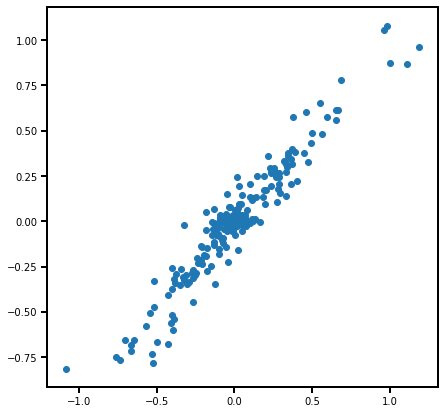

In [145]:
plt.figure(figsize=(7,7))
plt.scatter(all_dft_f[::10], all_nn_f[::10])
#plt.plot([-0.05, 0.05], [-0.05, 0.05 ])
# plt.xlim(-0.1, 0.1)
# plt.ylim(-0.1, 0.1)
plt.show()

In [146]:
t_len = 1000
t_sim  = 100

qt_data = torch.Tensor(traj[:t_len]).to(device)

In [147]:
qt.shape

torch.Size([100, 12, 3])

In [148]:
qt_data.shape

torch.Size([1000, 12, 3])

In [149]:
train_traj = []

for epoch in range(15):
    optimizer.zero_grad()
    
    sim = Simulations(system, diffeq)
    vt, qt, pvt = sim.simulate(steps=t_sim , frequency=t_sim , dt=dt)
    #print(qt[0])
    loss = (qt[::2] - qt_data[::20]).pow(2).mean()
    
    del system.traj
    
    if epoch % 20 == 0:
        train_traj.append(qt.detach().cpu())
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(loss.item())

0.02068423479795456
0.02068461664021015
0.02068500593304634
0.020685380324721336
0.020685764029622078
0.02068614587187767
0.020686516538262367
0.020686930045485497
0.020687315613031387
0.020687730982899666
0.020688125863671303
0.02068805694580078
0.02068846859037876
0.0206888560205698
0.020689258351922035


In [140]:
# visualize methane trajectory 

qt[::2][-1] - qt_data[::20][-1]

tensor([[ 0.2710, -0.3149, -0.0649],
        [ 0.1649,  0.0363, -0.0531],
        [ 0.0054, -0.2364,  0.0273],
        [-0.1501, -0.3743, -0.0428],
        [-0.2232, -0.1687, -0.0741],
        [-0.1304, -0.1993,  0.0615],
        [ 0.2890, -0.3319, -0.4268],
        [ 0.3928, -0.0387, -0.2261],
        [ 0.0095,  0.2563, -0.0454],
        [ 0.0850, -0.4088, -0.1172],
        [-0.1539,  0.0389, -0.4073],
        [-0.0973, -0.5548,  0.1599]], device='cuda:2', grad_fn=<SubBackward0>)

In [139]:
methane_nn_traj = [Atoms(positions=xyz, numbers=system.get_atomic_numbers()) for xyz in qt.detach().cpu().numpy()]
ase.io.write("benzene_nn.pdb", methane_nn_traj)
methane_nn_traj = mdtraj.load_pdb("benzene_nn.pdb")
show_mdtraj(methane_nn_traj)

NGLWidget(max_frame=99)

In [262]:
atoms.get_temperature()

11.926000603409328

In [155]:
# EMT or LJ
uracil = np.load("../data/uracil_dft.npz")
uracil_traj = [Atoms(positions=xyz, numbers=uracil.f.z)  for xyz in uracil.f.R[:2000]]
ase.io.write("uracil.pdb", uracil_traj)
ethanol_pdb_traj = mdtraj.load_pdb("uracil.pdb")
show_mdtraj(ethanol_pdb_traj)

NGLWidget(max_frame=1999)

In [366]:
device = 2
atoms = Atoms(positions=uracil.f.R[0], numbers=uracil.f.z)  

In [367]:
vel_init = (uracil.f.R[1] - uracil.f.R[0])/ ( 0.5 * units.fs )

In [368]:
atoms.set_velocities(vel_init)
system = System(atoms, device=device)

In [369]:
# Initialize FF 

model = get_model(gnn_params)
GNN = GNNPotentials(model, system.get_batch(), system.get_cell_len(), cutoff=5.0, device=system.device)

# define the equation of motion to propagate 
diffeq = NoseHooverChain(GNN, 
        system,
        Q=50.0, 
        T=500.0 * units.kB,
        num_chains=5, 
        adjoint=True).to(device)

In [370]:
optimizer = torch.optim.Adam(list(diffeq.parameters() ), lr=1e-5)

In [372]:
t_len = 50
dt = 0.5
qt_data = torch.Tensor( uracil.f.R[:t_len] ).to(device)

In [373]:
train_traj = []

for epoch in range(1000):
    sim = Simulations(system, diffeq)
    vt, qt, pvt = sim.simulate(steps=t_len, frequency=t_len, dt=0.5 * units.fs)
    loss = (qt - qt_data).pow(2).mean()
    
    del system.traj
    
    if epoch % 20 == 0:
        train_traj.append(qt.detach().cpu())
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(loss.item())

0.02992996573448181
0.029708489775657654
0.029538286849856377
0.02936713397502899
0.02919200249016285
0.02901315502822399
0.028831597417593002
0.028648309409618378
0.02846444584429264
0.02828098088502884
0.02809853106737137
0.02791733667254448
0.027737241238355637
0.027557315304875374
0.027375908568501472
0.02719098888337612
0.026999881491065025
0.026799600571393967
0.026586176827549934
0.02635430172085762
0.026095399633049965
0.025794507935643196
0.025423334911465645
0.02491236850619316
0.023972420021891594
0.023850195109844208
0.02375594526529312
0.0236574225127697
0.023557567968964577
0.023456821218132973
0.02335529401898384
0.02325277402997017
0.023149173706769943
0.023044323548674583
0.02293800748884678
0.022830117493867874
0.022720277309417725
0.022608334198594093
0.022493911907076836
0.022376645356416702
0.022256040945649147
0.022131560370326042
0.02200237289071083
0.02186768501996994
0.021726185455918312
0.021576035767793655
0.02141452208161354
0.021237026900053024
0.0210350323

0.008812818676233292
0.00880639348179102
0.008800026960670948
0.008793669752776623
0.008787356317043304
0.008781078271567822
0.008774828165769577
0.008768612518906593
0.008762428537011147
0.008756277151405811
0.008750168606638908
0.008744078688323498
0.008738018572330475
0.00873199850320816
0.008726011030375957
0.008720049634575844
0.008714123629033566
0.008708230219781399
0.008702355436980724
0.008696514181792736
0.008690706454217434
0.008684917353093624
0.008679168298840523
0.008673432283103466
0.008667736314237118
0.008662072941660881
0.008656436577439308
0.008650814183056355
0.008645239286124706
0.008639674633741379
0.008634134195744991
0.008628633804619312
0.008623150177299976
0.00861769262701273
0.008612268604338169
0.008606850169599056
0.008601467125117779
0.008596127852797508
0.00859079509973526
0.008585482835769653
0.008580200374126434
0.008574948646128178
0.008569713681936264
0.008564508520066738
0.008559312671422958
0.008554146625101566
0.008549009449779987
0.008543890900909

0.0073691485449671745
0.007366395555436611
0.0073636495508253574
0.007360887713730335
0.00735812820494175
0.0073553756810724735
0.007352616637945175
0.0073498631827533245
0.00734711205586791
0.0073443506844341755
0.007341605145484209
0.0073388549499213696
0.007336101494729519
0.007333350367844105
0.007330592256039381
0.00732784066349268
0.00732509745284915
0.007322344463318586
0.007319596130400896
0.007316846400499344
0.0073140948079526424
0.007311346475034952
0.007308598607778549
0.007305847015231848
0.007303101476281881
0.007300350349396467
0.0072975982911884785
0.007294859737157822
0.007292110938578844
0.007289373781532049
0.007286618929356337
0.007283868733793497
0.007281123660504818
0.007278375327587128
0.00727563351392746
0.007272881921380758
0.007270134054124355
0.007267397828400135
0.007264654617756605
0.0072619011625647545
0.007259153760969639
0.007256409619003534
0.007253670133650303
0.007250922732055187
0.0072481706738471985
0.0072454349137842655
0.007242676801979542
0.00723

In [376]:
# run longer time 

t_len = 100
qt_data = torch.Tensor( uracil.f.R[:t_len] ).to(device)

sim = Simulations(system, diffeq)
vt, qt_test, pvt = sim.simulate(steps=t_len, frequency=t_len, dt=0.5 * units.fs)
del system.traj

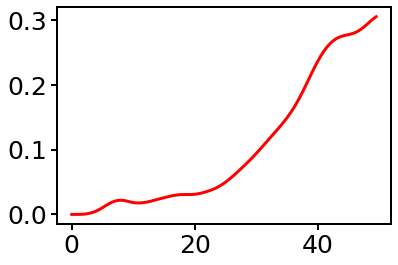

In [378]:
plt.plot([i * dt for i in range(t_len)], 
     (qt_test.detach().cpu() - qt_data.detach().cpu()).pow(2).sum(-1).mean(1).detach().cpu().numpy(), 
     c='red' ) 

plt.show()

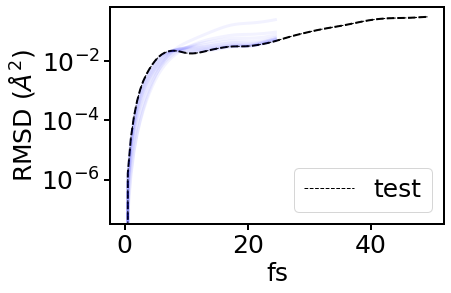

In [392]:

t_len_test = 100   
qt_data = torch.Tensor( uracil.f.R[:t_len_test ] ).to(device)    
plt.plot([i * dt for i in range(t_len_test)], 
     (qt_test.detach().cpu() - qt_data.detach().cpu()).pow(2).sum(-1).mean(1).detach().cpu().numpy(), 
     c='black', linestyle='--', linewidth=2 )     

t_len_train = 50
for i, rmsd in enumerate(train_traj[::5]):
    qt_data = torch.Tensor( uracil.f.R[:t_len_train] ).to(device)
    label = 'epoch {}'.format(i)
    plt.plot([i * dt for i in range(t_len_train)], 
         (rmsd - qt_data.detach().cpu()).pow(2).sum(-1).mean(1).detach().cpu().numpy(), 
         alpha= 1- epoch * 0.01, color='blue')

t_len_test = 100   
qt_data = torch.Tensor( uracil.f.R[:t_len_test ] ).to(device)    
plt.plot([i * dt for i in range(t_len_test)], 
     (qt_test.detach().cpu() - qt_data.detach().cpu()).pow(2).sum(-1).mean(1).detach().cpu().numpy(), 
     c='black', linestyle='--', linewidth=1, label='test')     
    
plt.ylabel("RMSD ($\AA^2$)")
plt.xlabel("fs")
plt.yscale("log")
plt.legend()
plt.show()
plt.close()

In [384]:
rmsd.shape

torch.Size([50, 12, 3])

In [385]:
qt_data.shape

torch.Size([50, 12, 3])

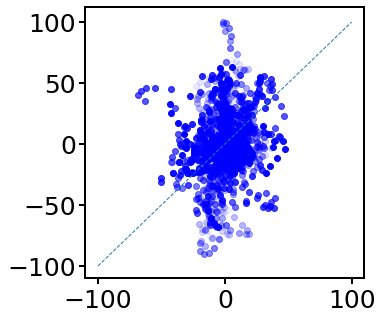

In [397]:
from nff.utils import compute_grad
# validate on the forces 
# compute
plt.figure(figsize=(5,5))

for i in range(50):
    
    x = qt[i].detach()
    x.requires_grad = True
    u = diffeq.model(x)
    f = -compute_grad(x, u) * 23.061
    plt.scatter(f.detach().cpu().numpy(),  uracil.f.F[i], alpha=1-0.02 * i, color='b')
    
plt.plot([-100, 100], [-100, 100], linewidth=1, linestyle='--')
    
plt.show()

In [229]:
atoms.get_number_of_atoms()

12

In [228]:
bath = torch.nn.Sequential( 
        torch.nn.Linear(12,12),
        torch.nn.Tanh(),
        torch.nn.Linear(12,12),
        torch.nn.Tanh(), 
        torch.nn.Linear(12,12),
        torch.nn.Tanh(), 
        torch.nn.Linear(12,12),
    )

In [138]:
# Plot NN MSE 

def plot_rmsd(qt, qt_data, t_len, dt=0.5):

    plt.plot([i * dt for i in range(t_len)], 
             (qt - qt_data).pow(2).sum(-1).mean(1).detach().cpu().numpy() )
    plt.ylabel("RMSD ($\AA^2$)")
    plt.xlabel("fs")
    plt.show()

In [402]:
# show movie 

uracil_nn_traj = [Atoms(positions=xyz, numbers=uracil.f.z) for xyz in qt_test.detach().cpu().numpy()]
ase.io.write("uracil_nn.pdb", uracil_nn_traj)
uracil_nn_traj = mdtraj.load_pdb("uracil_nn.pdb")
show_mdtraj(uracil_nn_traj)

NGLWidget(max_frame=99)

In [400]:
uracil = np.load("../data/uracil_dft.npz")
uracil_traj = [Atoms(positions=xyz, numbers=uracil.f.z)  for xyz in uracil.f.R[:t_len_train]]
ase.io.write("uracil.pdb", uracil_traj)
uracil_pdb_traj = mdtraj.load_pdb("uracil.pdb")
show_mdtraj(uracil_pdb_traj)

NGLWidget(max_frame=49)